In [ ]:
#TODO: Trobubleshoot why this always seems to be "overshooting" coords from the origin, leading to lines that fit poorly

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from hsdfmpm.mpm import InstrumentResponseFunction
from hsdfmpm.mpm.flim.utils import get_phasor_coordinates, polar_from_cartesian, cartesian_from_polar, \
    plot_universal_circle, fit_phasor, cartesian_from_lifetime, find_intersection_with_circle, project_to_line, \
    lifetime_from_cartesian, get_endpoints_from_projection

rng = np.random.default_rng(42)
omega = 2 * np.pi * 80e6

def generate_decay(t, tau1, tau2=None, alpha=1.0, total_photons=1e3):
    if tau2 is None:
        alpha = 1.0
        tau2 = 1
    decay1 = np.exp(-t / tau1)
    decay2 = np.exp(-t / tau2)
    decay1 /= np.sum(decay1, axis=-1, keepdims=True)
    decay2 /= np.sum(decay2, axis=-1, keepdims=True)
    decay = total_photons * (alpha * decay1 + (1 - alpha) * decay2)
    return decay

def add_noise(decay):
    total_photons = np.sum(decay, axis=-1, keepdims=True)
    decay /= total_photons
    expected = decay * total_photons
    return rng.poisson(expected, size=decay.shape)

def convolve_with_irf(decay, irf):
    while decay.ndim < irf.ndim:
        decay = np.expand_dims(decay, axis=0)
    T = decay.shape[-1]
    decay_area = np.sum(decay, axis=-1, keepdims=True)
    conv_L = decay.shape[-1] + irf.shape[-1] -  1
    decay = np.fft.fft(decay / decay_area, n=conv_L, axis=-1)
    irf = np.fft.fft(irf / irf.sum(axis=-1, keepdims=-1), n=conv_L, axis=-1)
    decay *= irf
    decay = np.fft.ifft(decay, axis=-1).real
    return decay[..., :T] * decay_area

# IRF

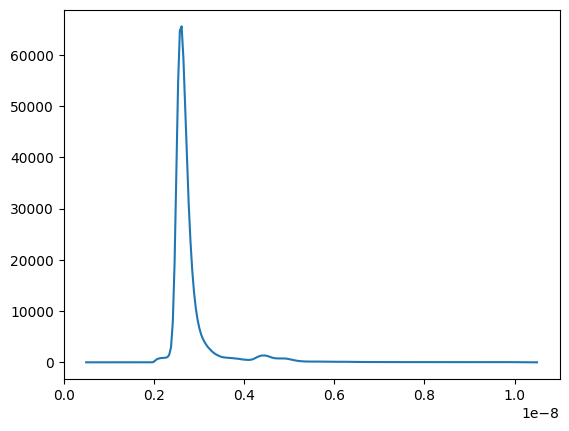

In [52]:
t = np.linspace(0.5, 10.5, 256) / 1e9
irf = InstrumentResponseFunction.load()
plt.plot(t, np.sum(irf.decay, axis=(0, 1, 2)))
plt.show()

## Visualize IRF correction

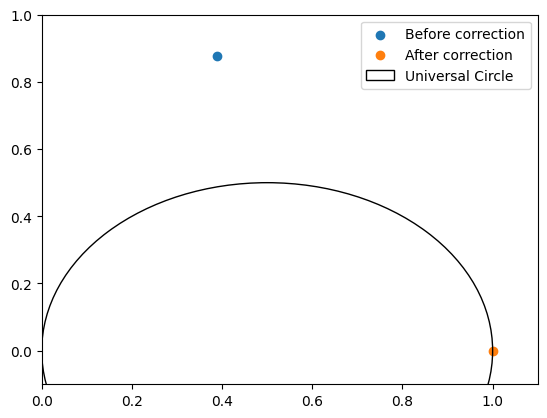

In [53]:
g, s, photons = get_phasor_coordinates(irf.decay)
plt.scatter(g.flatten(), s.flatten(), label="Before correction")
phase_shift = irf.phase_offset
modulation_factor = irf.modulation_factor
phi, mod = polar_from_cartesian(g, s)
phi += phase_shift
mod *= modulation_factor
g, s = cartesian_from_polar(phi, mod)
plt.scatter(g.flatten(), s.flatten(), label="After correction")
plot_universal_circle(omega)
plt.xlim((0, 1.1))
plt.ylim((-0.1, 1))
plt.legend()
plt.show()

# Simualte some data

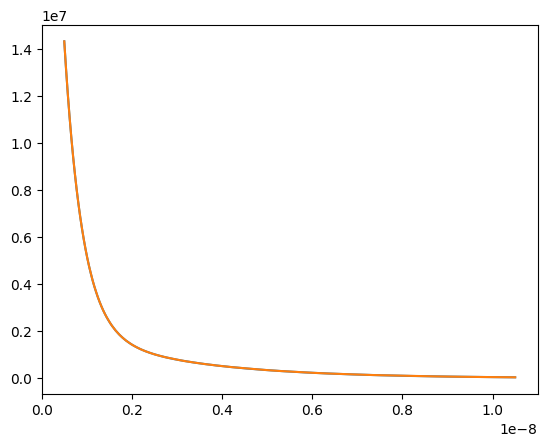

In [54]:
tau1_value = 0.4e-9
tau2_value = 2.5e-9
alpha_range = [0.45, 0.55]
tau1 = np.ones((512, 512, 1)) * tau1_value
tau2 = np.ones((512, 512, 1)) * tau2_value
alpha = alpha_range[0] + rng.random((512, 512, 1)) * np.diff(alpha_range)
decay = generate_decay(t, tau1=tau1, tau2=tau2, alpha=alpha)
decay = decay[np.newaxis, ...]
plt.plot(t, np.sum(decay, axis=(0, 1, 2)))
decay = add_noise(decay)
plt.plot(t, np.sum(decay, axis=(0, 1, 2)))
plt.show()


## Pre-convolution decay

### Get phasor

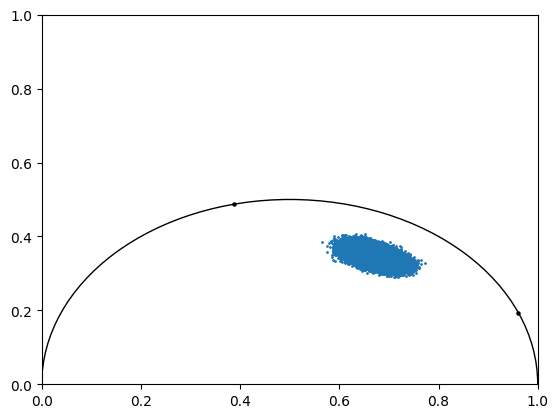

In [55]:
g, s, photons = get_phasor_coordinates(decay)
plt.scatter(g.flatten(), s.flatten(), s=1)
plot_universal_circle(omega, tau_labels=[tau1_value, tau2_value])
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.show()

## Compare with ground truth in phasor space

Average distance: 0.03


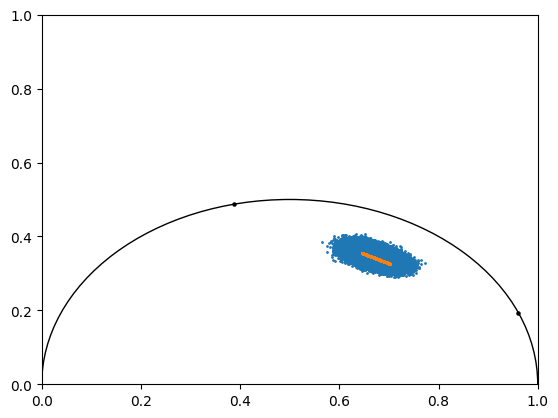

In [56]:
g1, s1 = cartesian_from_lifetime(tau1, omega)
g2, s2 = cartesian_from_lifetime(tau2, omega)
x, y = alpha * g1 + (1-alpha) * g2, alpha * s1 + (1-alpha) * s2
distance = np.mean(np.hypot(g - x, s - y))
print(f'Average distance: {distance:.2f}')
plt.scatter(g.flatten(), s.flatten(), s=1)
plot_universal_circle(omega, tau_labels=[tau1_value, tau2_value])
plt.scatter(x.flatten(), y.flatten(), s=1)
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.show()

## Compare with ground truth in Tau/alpha

In [57]:
b, m = fit_phasor(g, s)
x, y = find_intersection_with_circle(b, m)
gp, sp = project_to_line(g, s, x, y)
tau = lifetime_from_cartesian(x, y, omega)
alphas, tau_m = get_endpoints_from_projection(gp, sp, x, y, tau)

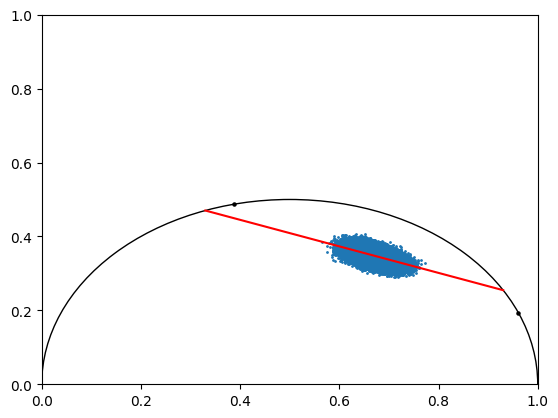

In [58]:
plt.scatter(g.flatten(), s.flatten(), s=1)
plot_universal_circle(omega, tau_labels=[tau1_value, tau2_value])
plt.plot(x, y, 'red')
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.show()

In [59]:
tau_arr = np.array([tau1_value, tau2_value])
tau_error = np.mean((tau - tau_arr) / tau_arr)
print(f'Taus error: {100 * tau_error:.2f}%')

alpha_error = np.mean((alphas[0] - alpha) / alpha)
print(f'Alpha error: {100 * alpha_error:.2f}%')

Taus error: 24.76%
Alpha error: 14.92%


In [60]:
tm2 = np.sum(alphas * tau[...,np.newaxis,np.newaxis], axis=0)
tm = np.sum(tau1_value * alpha + tau2_value * (1 - alpha), axis=-1)
mean_error = np.mean((tm2 - tm) / tm)
print(f'Mean lifetime error: {100 * mean_error:.2f}%')

Mean lifetime error: 5.07%


## Convolved

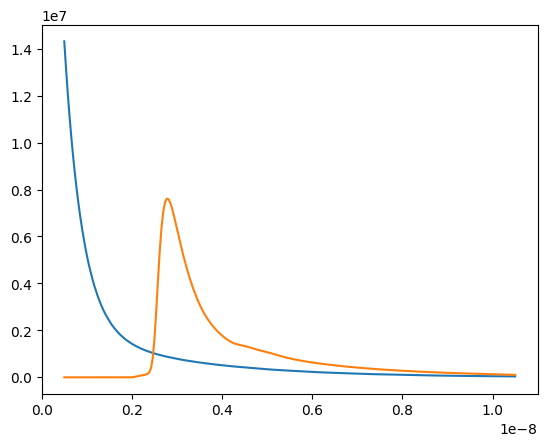

In [61]:
plt.plot(t, np.sum(decay, axis=(0, 1, 2)))
decay = convolve_with_irf(decay, irf.decay)
plt.plot(t, np.sum(decay, axis=(0, 1, 2)))
plt.show()

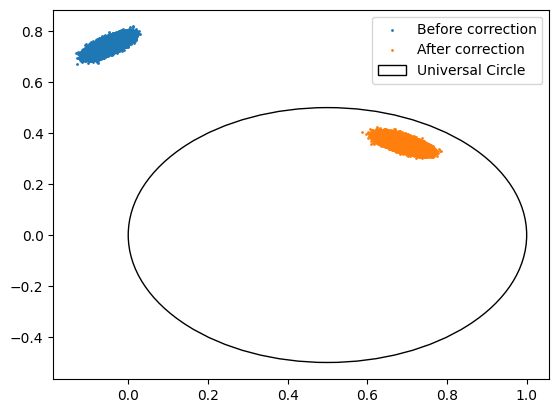

In [62]:
g3, s3, photons = get_phasor_coordinates(decay)
plt.scatter(g3.flatten(), s3.flatten(), s=1, label="Before correction")
phi, mod = polar_from_cartesian(g3, s3)
phi += phase_shift
mod *= modulation_factor
g3, s3 = cartesian_from_polar(phi, mod)
plt.scatter(g3.flatten(), s3.flatten(), s=1, label="After correction")
plot_universal_circle(omega)
plt.legend()
plt.show()

In [63]:
loss = np.mean(np.sqrt((g3 - g) ** 2 + (s3 - s) ** 2))
print(f'Average distance from pre-convolution in phasor space: {loss:.4f}')
g1, s1 = cartesian_from_lifetime(tau1, omega)
g2, s2 = cartesian_from_lifetime(tau2, omega)
x, y = alpha * g1 + (1-alpha) * g2, alpha * s1 + (1-alpha) * s2
loss = np.mean(np.hypot(g3 - x, s3 - y))
print(f'Average distance from ground-truth in phasor space: {loss:.4f}')

Average distance from pre-convolution in phasor space: 0.0229
Average distance from ground-truth in phasor space: 0.0394


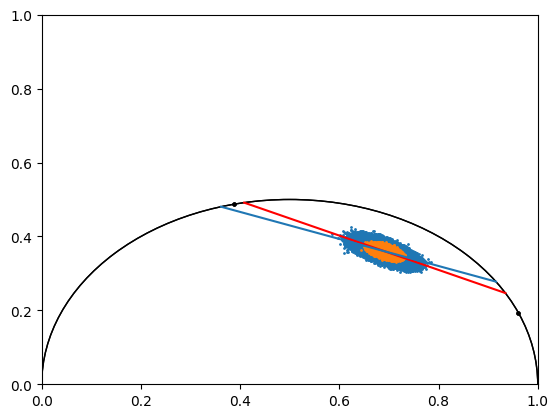

Taus error: 28.28%
Alpha error: 20.00%


In [64]:
from scipy.ndimage import median_filter
g, s = g3, s3
b, m = fit_phasor(g, s)
x, y = find_intersection_with_circle(b, m)
gp, sp = project_to_line(g, s, x, y)
tau = lifetime_from_cartesian(x, y, omega)
alphas, tau_m = get_endpoints_from_projection(gp, sp, x, y, tau)
plt.scatter(g.flatten(), s.flatten(), s=1)
plot_universal_circle(omega, tau_labels=[tau1_value, tau2_value])
plt.plot(x, y, 'red')

g, s = median_filter(g.squeeze(), (3, 3))[np.newaxis, ...], median_filter(s.squeeze(), (3, 3))[np.newaxis, ...]
b, m = fit_phasor(g, s)
x, y = find_intersection_with_circle(b, m)
gp, sp = project_to_line(g, s, x, y)
tau = lifetime_from_cartesian(x, y, omega)
alphas, tau_m = get_endpoints_from_projection(gp, sp, x, y, tau)
plt.scatter(g.flatten(), s.flatten(), s=1)
plot_universal_circle(omega, tau_labels=[tau1_value, tau2_value])
plt.plot(x, y)

plt.xlim((0, 1))
plt.ylim((0, 1))
plt.show()
tau_arr = np.array([tau1_value, tau2_value])
tau_error = np.mean((tau - tau_arr) / tau_arr)
print(f'Taus error: {100 * tau_error:.2f}%')

alpha_error = np.mean((alphas[0] - alpha) / alpha)
print(f'Alpha error: {100 * alpha_error:.2f}%')

In [65]:
tm2 = np.sum(alphas * tau[...,np.newaxis,np.newaxis], axis=0)
tm = np.sum(tau1_value * alpha + tau2_value * (1 - alpha), axis=-1)
mean_error = np.mean((tm2 - tm) / tm)
print(f'Mean lifetime error: {100 * mean_error:.2f}%')

Mean lifetime error: -1.67%


# Sweep through several

In [66]:
from tqdm.contrib import itertools
rng = np.random.default_rng(42)
omega = 2 * np.pi * 80e6
t = np.linspace(0.5, 10.5, 256) / 1e9

In [ ]:
# Generate arrays of two lifetime species
tau1_value_arr = np.arange(0.1, 1, 0.05) * 1e-9
tau2_value_arr = np.arange(1.5, 8, 0.25) * 1e-9
T1, T2, TM, PT1, PT2, PTM, AM, AS, CO, RD, TE, AE, FE, ME = [], [], [], [], [], [], [], [], [], [], [], [], [], []
for t1, t2 in itertools.product(tau1_value_arr, tau2_value_arr):
    tau1 = np.ones((512, 512, 1)) * t1
    tau2 = np.ones((512, 512, 1)) * t2
    alpha = rng.random((512, 512, 1))


    for convolved in [False, True]:
        T1.append(t1)
        T2.append(t2)
        AM.append(np.mean(alpha))
        AS.append(np.std(alpha))

        decay = generate_decay(t, tau1=tau1, tau2=tau2, alpha=alpha)
        decay = decay[np.newaxis, ...]
        decay = add_noise(decay)
        CO.append(1 if convolved else 0)
        if convolved:
            decay = convolve_with_irf(decay, irf.decay)

        g, s, photons = get_phasor_coordinates(decay)

        if convolved:
            phi, mod = polar_from_cartesian(g, s)
            phi += phase_shift
            mod *= modulation_factor
            g, s = cartesian_from_polar(phi, mod)

        # Raw distance
        x1, y1 = cartesian_from_lifetime(t1, omega)
        x2, y2 = cartesian_from_lifetime(t2, omega)
        x, y = alpha * x1 + (1-alpha) * x2, alpha * y1 + (1-alpha) * y2

        # Fit a line
        b, m = fit_phasor(g, s)
        xs, ys = find_intersection_with_circle(b, m)
        gp, sp = project_to_line(g, s, xs, ys)
        tau = lifetime_from_cartesian(xs, ys, omega)
        alphas, tau_m = get_endpoints_from_projection(gp, sp, xs, ys, tau)
        tm = np.sum(t1 * alpha + t2 * (1 - alpha), axis=-1)

        # Capture values
        PT1.append(tau[0])
        PT2.append(tau[1])
        PTM.append(np.nanmean(tau_m))
        TM.append(np.nanmean(tm))

        # Error metrics
        raw_distance = np.nanmean(np.hypot(g - x, s - y))
        RD.append(raw_distance)

        tau_arr = np.array([t1, t2])
        tau_error = np.nanmean((tau - tau_arr) / tau_arr)
        TE.append(tau_error)

        alpha_error = np.nanmean((alphas[0] - alpha.squeeze()) / alpha.squeeze())
        AE.append(alpha_error)
        frac = ((1 - alpha) / alpha).squeeze()
        frac_error = np.nanmean(((alphas[1] / np.sum(alphas, axis=0)) - frac) / frac)
        FE.append(frac_error)

        mean_error = np.nanmean((tau_m - tm) / tm)
        ME.append(mean_error)

        print(f'T1:{1e9 * t1:.4f}ns, T2:{1e9 * t2:0.4f}ns, AM:{AM[-1]:0.4f}, CO:{convolved}, RD:{raw_distance:0.4f}, '
              f'tau_error:{tau_error * 100:0.4f}%, alpha_error:{alpha_error * 100:0.4f}%, frac_error:{frac_error * 100:0.4f}%, mean_error:{mean_error * 100:0.4f}%')

df = pd.DataFrame({
    'tau1': T1,
    'tau2': T2,
    'taum': TM,
    'predicted_tau1': PT1,
    'predicted_tau2': PT2,
    'predicted_average_tau_m': PTM,
    'Mean Alpha': AM,
    'Std Alpha': AS,
    'Convolved': CO,
    'Raw Distance': RD,
    'Tau Error': TE,
    'Alpha Error': AE,
    'Mean Error': ME,
})

  0%|          | 0/468 [00:00<?, ?it/s]

T1:0.1000ns, T2:1.5000ns, AM:0.5002, CO:False, RD:0.1877, tau_error:2.4824%, alpha_error:18.8924%, frac_error:-48.6391%, mean_error:-0.0661%
T1:0.1000ns, T2:1.5000ns, AM:0.5002, CO:True, RD:0.1884, tau_error:-10.6169%, alpha_error:16.7964%, frac_error:-48.0261%, mean_error:-4.9692%
T1:0.1000ns, T2:1.7500ns, AM:0.5004, CO:False, RD:0.2083, tau_error:2.1659%, alpha_error:45.1490%, frac_error:-49.0969%, mean_error:-0.0498%
T1:0.1000ns, T2:1.7500ns, AM:0.5004, CO:True, RD:0.2095, tau_error:-11.8437%, alpha_error:197.8173%, frac_error:-47.7278%, mean_error:-5.5168%
T1:0.1000ns, T2:2.0000ns, AM:0.4994, CO:False, RD:0.2252, tau_error:1.6681%, alpha_error:12.9845%, frac_error:-47.4549%, mean_error:-0.0709%
T1:0.1000ns, T2:2.0000ns, AM:0.4994, CO:True, RD:0.2273, tau_error:-13.1121%, alpha_error:33.3424%, frac_error:-45.5864%, mean_error:-6.4947%
T1:0.1000ns, T2:2.2500ns, AM:0.5000, CO:False, RD:0.2402, tau_error:1.3428%, alpha_error:12.8732%, frac_error:-48.9448%, mean_error:-0.1083%
T1:0.1000